In [2]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [3]:
# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_osaka'

In [4]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.23.0'

## Step 1: Map classical inputs to a quantum problem

In [7]:
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
# )

hamiltonian = SparsePauliOp.from_list(
    [("IIII", -0.0996), 
     ("IIIZ", 0.1711), 
     ("IIZI", 0.1711), 
     ("IZII", -0.2225), 
     ("ZIII", -0.2225), 
     ("IIZZ", 0.1686), 
     ("IZIZ", 0.1205), 
     ("ZIIZ", 0.1658), 
     ("IZZI", 0.1658), 
     ("ZIZI", 0.1205), 
     ("ZZII", 0.1743), 
     ("XYYX", 0.0453), 
     ("YXXY", 0.0453), 
     ("YYXX", -0.0453), 
     ("XXYY", -0.0453)]
)

In [8]:
hamiltonian

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII', 'XYYX', 'YXXY', 'YYXX', 'XXYY'],
              coeffs=[-0.0996+0.j,  0.1711+0.j,  0.1711+0.j, -0.2225+0.j, -0.2225+0.j,
  0.1686+0.j,  0.1205+0.j,  0.1658+0.j,  0.1658+0.j,  0.1205+0.j,
  0.1743+0.j,  0.0453+0.j,  0.0453+0.j, -0.0453+0.j, -0.0453+0.j])

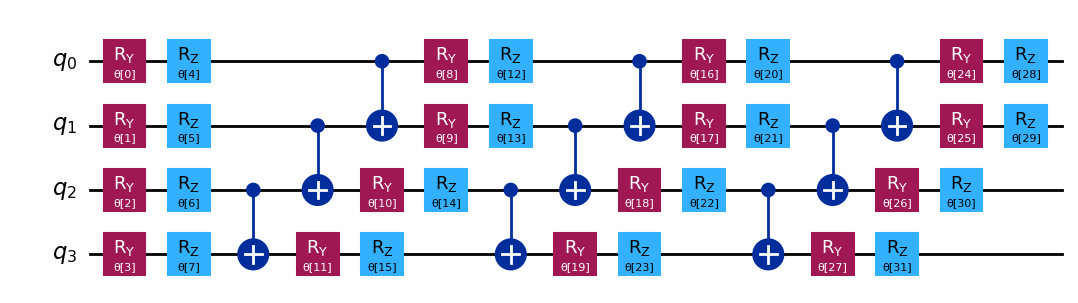

In [9]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl", style="iqp")

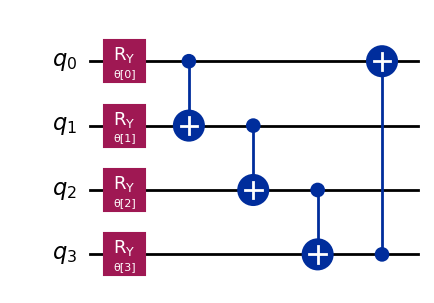

In [12]:
from qiskit.circuit.library import TwoLocal

entangler_map = [[0, 1], [1, 2], [2,3], [3,0]]  # entangle the first and last two-way
ansatz = TwoLocal(hamiltonian.num_qubits, 'ry', 'cx', entangler_map, reps=1, skip_final_rotation_layer=True)

ansatz.decompose().draw("mpl", style="iqp")

In [13]:
num_params = ansatz.num_parameters
num_params

4

## Step 2: Optimize problem for quantum execution.

In [14]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

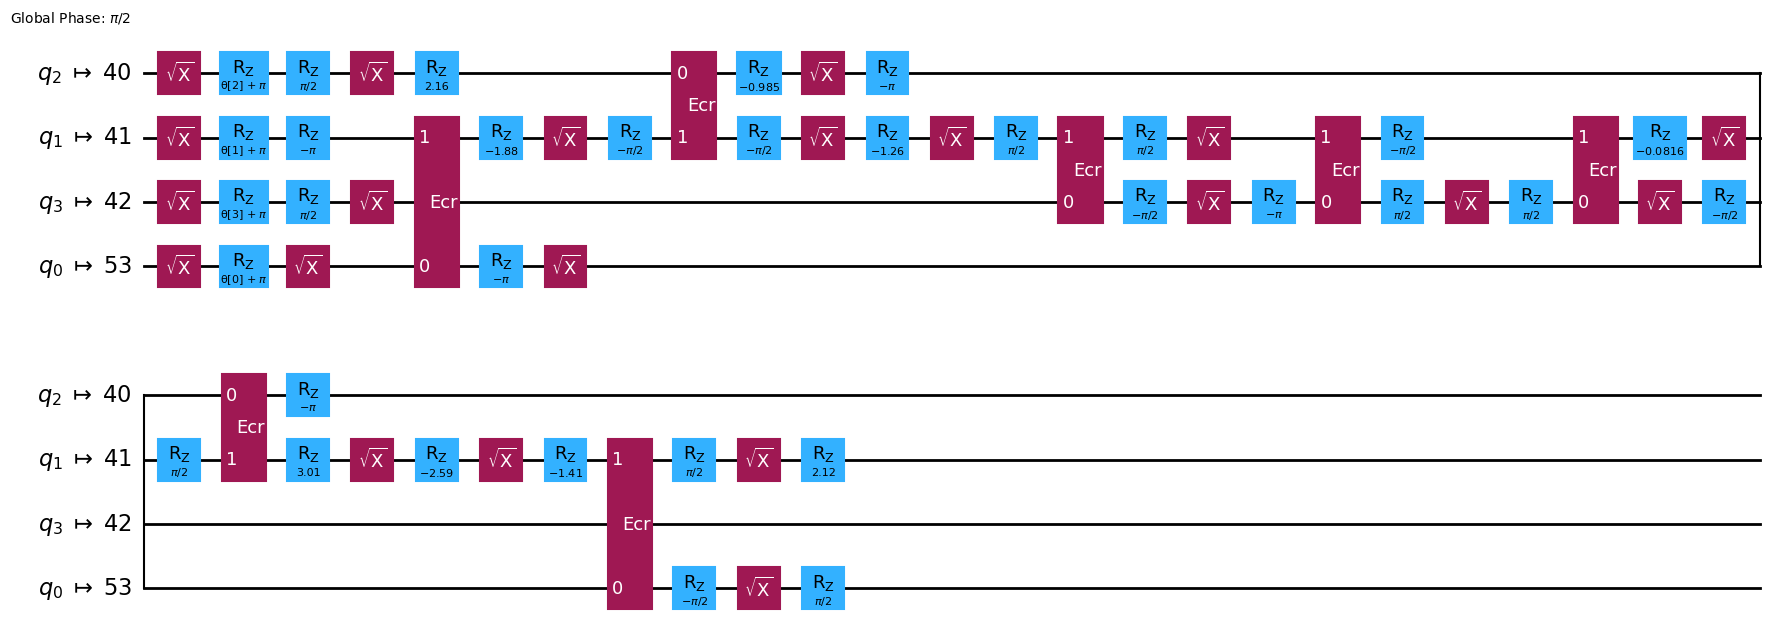

In [15]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [16]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3: Execute using Qiskit Primitives.

### Nelder-Mead Optimizer

In [17]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [18]:
x0 = 2 * np.pi * np.random.random(num_params)
x0

array([2.91915334, 1.73936636, 2.94509516, 1.05496598])

In [21]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 200

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="Nelder-Mead",
    )

Iters. done: 1 [Current cost: -0.2880398470054028]
Iters. done: 2 [Current cost: -0.24508055761363395]
Iters. done: 3 [Current cost: -0.17925003325837646]
Iters. done: 4 [Current cost: -0.1293468176055972]
Iters. done: 5 [Current cost: -0.2872017000103495]
Iters. done: 6 [Current cost: -0.25810488572124846]
Iters. done: 7 [Current cost: -0.278375218453466]
Iters. done: 8 [Current cost: -0.2407303390386556]
Iters. done: 9 [Current cost: -0.19231138656327215]
Iters. done: 10 [Current cost: -0.27084776694176327]
Iters. done: 11 [Current cost: -0.2679745380952293]
Iters. done: 12 [Current cost: -0.2303498673372928]
Iters. done: 13 [Current cost: -0.1392957854268212]
Iters. done: 14 [Current cost: -0.22169081217723066]
Iters. done: 15 [Current cost: -0.24564753236146852]
Iters. done: 16 [Current cost: -0.259933642120588]
Iters. done: 17 [Current cost: -0.24884554599267705]
Iters. done: 18 [Current cost: -0.2317644854624395]
Iters. done: 19 [Current cost: -0.11507921568125326]
Iters. done: 2

KeyboardInterrupt: 

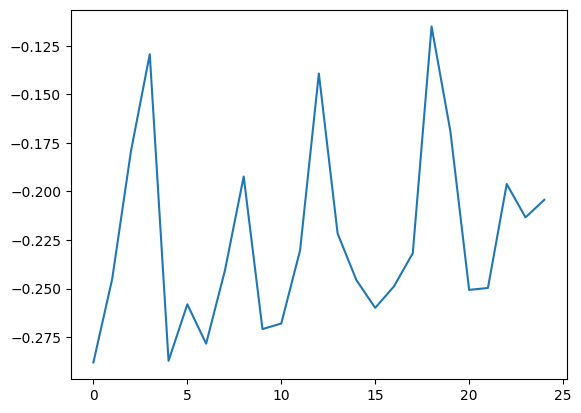

In [24]:
cost_history_dict
plt.plot(cost_history_dict['cost_history'])

### COBYLA

In [25]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 200

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

Iters. done: 26 [Current cost: -0.20393760377761488]
Iters. done: 27 [Current cost: -0.19785614011850605]
Iters. done: 28 [Current cost: 0.08795246401395772]
Iters. done: 29 [Current cost: -0.13775712706493212]
Iters. done: 30 [Current cost: -0.43052918367014026]
Iters. done: 31 [Current cost: -0.5230726536643745]
Iters. done: 32 [Current cost: -0.43349552489378973]
Iters. done: 33 [Current cost: -0.5365944293074614]
Iters. done: 34 [Current cost: -0.5009373050451049]
Iters. done: 35 [Current cost: -0.4448438985543533]


capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.


IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

3


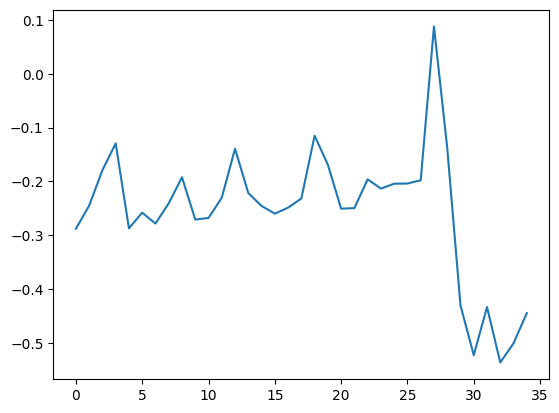

In [28]:
print(len(cost_history_dict))
plt.plot(cost_history_dict['cost_history'])

3


(-1.2, 0.0)

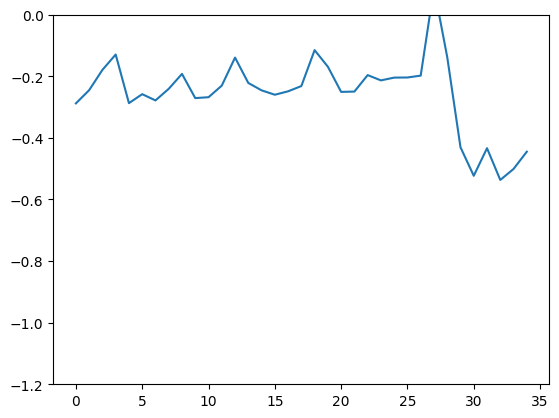

In [29]:
print(len(cost_history_dict))
plt.plot(cost_history_dict['cost_history'])
plt.ylim(-1.2, 0)

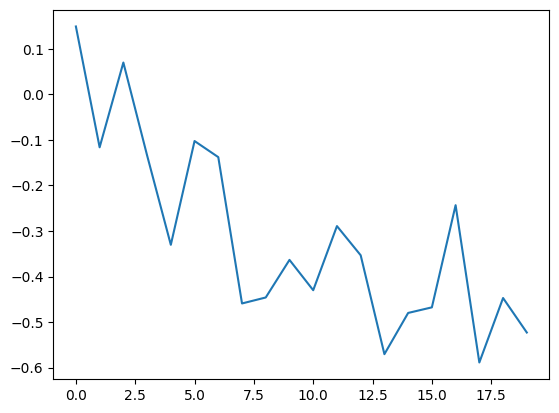

In [20]:
import matplotlib.pyplot as plt
cost = [0.14922586116758643, -0.11612803571621408, 0.07002776280206445, -0.13386988850633055, -0.3302387656462088, -0.10234731983003965, -0.13772207900026967, -0.45905039527309566, -0.445916509386791, -0.36337138067990404, -0.42997434693744946, -0.28915363465327376, -0.35322293062687277, -0.5704129149833769, -0.47988316089181043, -0.46759465876835415, -0.24320415638696258, -0.588662767522721, -0.44708847005466235, -0.5228542313152235]
plt.plot(cost)

## Step 4: Post-process, return result in classical format.

In [ ]:
all(cost_history_dict["prev_vector"] == res.x)

In [ ]:
cost_history_dict["iters"] == res.nfev

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [23]:
cost_history_dict

{'prev_vector': array([3.05888996, 4.43727613, 5.39903657, 5.66676143, 3.91592233,
        4.00972591, 4.42010001, 2.20419641, 1.54907842, 4.74382172,
        1.6739801 , 4.65247405, 5.86036756, 4.70397595, 0.87260049,
        1.27107314]),
 'iters': 20,
 'cost_history': [0.14922586116758643,
  -0.11612803571621408,
  0.07002776280206445,
  -0.13386988850633055,
  -0.3302387656462088,
  -0.10234731983003965,
  -0.13772207900026967,
  -0.45905039527309566,
  -0.445916509386791,
  -0.36337138067990404,
  -0.42997434693744946,
  -0.28915363465327376,
  -0.35322293062687277,
  -0.5704129149833769,
  -0.47988316089181043,
  -0.46759465876835415,
  -0.24320415638696258,
  -0.588662767522721,
  -0.44708847005466235,
  -0.5228542313152235]}

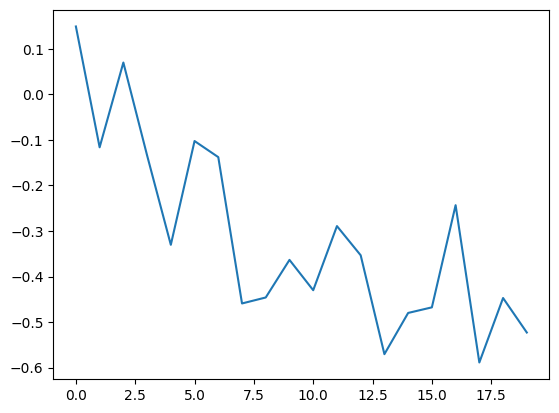

In [25]:
plt.plot(cost_history_dict['cost_history'])